In [87]:
import geopandas as gpd
import numpy as np
import pandas as pd
import ee
import geemap
from datetime import datetime
from pathlib import Path

import xyzservices



In [2]:
try:
    ee.Initialize()
except: 
    ee.Authenticate()
    ee.Initialize()

In [119]:
lines = gpd.read_file('arctic_transects.shp')

In [126]:
tile = xyzservices.providers.Esri.WorldImagery()
gpd.read_file('arctic_transects.shp').explore(tiles=tile,column='FID', style_kwds={'weight':10})

# Designate area of interest (AOI)

## Set up name and directory structure

This is where you can change the ID of the watershed

You can use geemap's `geemap.shp_to_ee()` function to turn a local shapefile into an AOI as well. 

# Define EE functions and get filtered ImageCollection

## Functions

In [4]:
def maskS2clouds(image):
        """Masks clouds in S2 images

    Parameters:
    image (Image): A single Image in an ImageCollection or standalone Image

    Returns:
    Image with masked features and original metadata

    """
        qa = image.select('QA60')

        # Bits 10 and 11 are clouds and cirrus, respectively.
        cloudBitMask = 1 << 10
        cirrusBitMask = 1 << 11

        # Both flags should be set to zero, indicating clear conditions.
        mask = qa.bitwiseAnd(cloudBitMask).eq(0) \
            .And(qa.bitwiseAnd(cirrusBitMask).eq(0))

        return image.updateMask(mask) \
            .divide(10000) \
            .copyProperties(image, ['system:time_start'])

def clp(image):
    '''Clips a single Image to a region of interest'''
    return image.clip(aoi)

def mosaicByDate(imcol):
        """Creates a mosaicked Image for a single date if there are
        multiple images from a single date 

    Parameters:
    imcol (ImageCollection): An ImageCollection with images from one or more dates

    Returns:
    ImageCollection with images mosaicked by date

        """
        # Get a list of unique dates in the image collection
        imlist = imcol.toList(imcol.size())

        unique_dates = imlist.map(lambda im: ee.Image(im).date().format("YYYY-MM-dd")).distinct().getInfo()

        # Create an empty list to store mosaic images
        mosaic_imlist = []

        # Loop through unique dates and create mosaic images
        for date_str in unique_dates:
            date = ee.Date.parse("YYYY-MM-dd", date_str)
            mosaic_image = imcol.filterDate(date, date.advance(1, "day")).mosaic()
            mosaic_image = mosaic_image.set("system:time_start", date.millis(), "system:id", date_str)
            mosaic_imlist.append(mosaic_image)

        return ee.ImageCollection(mosaic_imlist)

def addNDVI(image):
  '''Adds S2's NDVI band to each image (in an ImageCollection)'''
  ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
  return image.addBands(ndvi)

def addNDSI(image):
    '''Adds S2's NDSI band to each image (in an ImageCollection)'''
    ndsi = image.normalizedDifference(['B3', 'B11']).rename('NDSI')
    return image.addBands(ndsi)

def addElevation(image):
  '''Adds ArcticDEM elevation to each image (in an ImageCollection)'''
  elevation = ee.Image("UMN/PGC/ArcticDEM/V3/2m_mosaic").select('elevation').clip(aoi).rename('ArcticDEM')
  return image.addBands(elevation)

def get_mean_snow_cover(image):
        """Adds a value for scene-averaged MODIS-dervied snow cover to an image (in an ImageCollection)

    Parameters:
    image (Image): A single Image in an ImageCollection or standalone Image

    Returns:
    Image with snow cover mean as a band

        """    
        # Get MODIS snow cover product for day and location
        ndsi_image = ee.ImageCollection('MODIS/061/MOD10A1').filterDate(
            image.date(), image.date().advance(1, 'day')).first().select('NDSI_Snow_Cover').clip(aoi)
        
        image = image.addBands(ndsi_image)

        # Get mean value across the scene 
        mean_value = image.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=aoi,
            scale=100,  # Resolution of Landsat data in meters
            maxPixels = 1e9
        )

        # Get the mean value for the band
        mean_band_value = mean_value.get('NDSI_Snow_Cover')

        # Set the mean value as an image property
        return image.set("mean_" + 'NDSI_Snow_Cover', mean_band_value)

def calculateNoDataPercentage(image):
        """Add data on masked pixel percentage as a band
        note that total_pixels needs to be calculated first

    Parameters:
    image (Image): A single Image in an ImageCollection or standalone Image

    Returns:
    Image with "nodata_percentage band added"

    """
    
    # Any masked no data stuff will be equal to 1
        nodata_mask = image.select('B1').mask().eq(0)
            
        # Sum up the nodata 1's
        # nodata_pixels = nodata_mask.reduceRegion(
        #     reducer=ee.Reducer.sum(),
        #     geometry=aoi,
        #     scale=100,  # s2 res
        #     maxPixels = 1e9
        # )
        
        # # Calculate the percentage of NoData values
        # percentage_nodata = nodata_pixels.getNumber('B1').divide(total_pixels.getNumber('B1')).multiply(100)

        
        # # Set the NoData percentage as an image property
        # return image.set("nodata_percentage", percentage_nodata)  
        nodata_stats = nodata_mask.reduceRegion(
        reducer=ee.Reducer.sum().combine(
            reducer2=ee.Reducer.count(),
            sharedInputs=True
        ),
        geometry=aoi,  # Assuming 'aoi' is defined somewhere in your script
        scale=100,  # Adjust the scale according to your requirements
        maxPixels=1e9
        )

        # Extract sum and count values
        sum_nodata_pixels = nodata_stats.getNumber('B1_sum')
        count_nodata_pixels = nodata_stats.getNumber('B1_count')

        # Calculate percentage
        nodata_percentage = sum_nodata_pixels.divide(count_nodata_pixels).multiply(100)

        # Add NoData percentage as a band
        return image.set('nodata_percentage', nodata_percentage)


def get_white_pixel_percent(image):
        """Add data on pixel percentage that is white in grayscale as a band
        note that total_pixels needs to be calculated first

    Parameters:
    image (Image): A single Image in an ImageCollection or standalone Image

    Returns:
    Image with "white_percentage" band added

    """    
        grayscale = image.expression(
            '(.3 * 1e4 * R) + (.59 * 1e4 * G) + (.11 * 1e4 * B)', {
            # '(R + G + B) / 3', {
            'R': image.select('B4'),
            'G': image.select('B3'),
            'B': image.select('B2')
        })

        white_mask = grayscale.gt(2000)
        
        # white_mask needs to = 1

        # white_pixels = white_mask.reduceRegion(
        #     reducer=ee.Reducer.sum(),
        #     geometry=aoi,
        #     scale=100,  # s2 res
        #     maxPixels = 1e9
        # )

        # # # Calculate the total number of pixels within the ROI
        # # total_pixels = image.select('B1').reduceRegion(
        # #     reducer=ee.Reducer.count(),
        # #     scale=10,  # s2 res
        # #     maxPixels = 1e9
        # # )

        # # percentage_white = white_pixels.getNumber('constant').divide(total_pixels.getNumber('B1')).multiply(100)
        
        # total_pixels = image.getNumber('total_pixels')  # Get total_pixels from the image properties

        # percentage_white = white_pixels.getNumber('constant').divide(total_pixels).multiply(100)
        
        # # Set the NoData percentage as an image property
        # return image.set("white_percentage", percentage_white).set("white_pixel_count", white_pixels.getNumber('constant')) 
        white_pixel_stats = white_mask.reduceRegion(
        reducer=ee.Reducer.sum().combine(
                reducer2=ee.Reducer.count(),
                sharedInputs=True
            ),
            geometry=aoi,  # Assuming 'aoi' is defined somewhere in your script
            scale=100,  # Adjust the scale according to your requirements
            maxPixels=1e9
        )

        # Extract sum and count values
        sum_white_pixels = white_pixel_stats.getNumber('constant_sum')
        count_white_pixels = white_pixel_stats.getNumber('constant_count')

        # Calculate percentage
        white_percentage = sum_white_pixels.divide(count_white_pixels).multiply(100)

        return image.set("white_percentage", white_percentage)

def calcTotalPixels(image):
    """Add data on total pixels as a band

    Parameters:
    image (Image): A single Image in an ImageCollection or standalone Image

    Returns:
    Image with "total_pixels" band added

    """    
    total_pixels = image.select('B1').reduceRegion(
        reducer=ee.Reducer.count(),
        scale=100,  
        maxPixels = 1e9,
        geometry=aoi
    )
    return image.set("total_pixels", total_pixels.getNumber('B1')) 

def getVisibleImages(Map):
        """Retrieves names of layers visible on the Map 

    Parameters:
    Map (Map): A geemap.Map() 

    Returns:
    A list of strings corresponding to the labels on the Map layers
    if they are dates (as needed for the original notebook)

    """    
        map_layers = list(Map.layers)
        visibility_status = [layer.visible for layer in map_layers]
        visible_layers = [x.name for x, y in zip(map_layers, visibility_status) if y == True]
        return [x for x in visible_layers if '-' in x and datetime.strptime(x, '%Y-%m-%d')]


## Set filtering parameters 

If you notice that your ImageCollections are empty, try changing these!

## Build ImageCollection

This step involves loading in Sentinel 2 data and applies your first filter for dates and cloudy percentage as well as filtering to images that intersect with the bounds of your area of interest and masking for clouds. 

For detecting water tracks we want to look at the growing season (months 5 to 9) but adjust based on science question. 

In [11]:
# This line only instantiates a "Map" object from gee
# You need to make one to add layers to it
# but we don't display it yet 

# If you run this line after adding layers, 
# you will lose the layers because you made a new Map
Map = geemap.Map(center=[65.0619, -166.3062], zoom=11, basemap='Esri.WorldImagery')

In [89]:
elevation = ee.Image("UMN/PGC/ArcticDEM/V3/2m_mosaic").select('elevation').rename('ArcticDEM')

Map.addLayer(elevation, {}, "elevation",False)

contours = geemap.create_contours(elevation, 0, 3000, 3, region=None)

Map.addLayer(
    contours, {}, "contours"
)


# Map

Now if you click on the wrench in the right top corner, followed by the "Layers" button, you can toggle through imagery that passed the filter. 

If you notice squares missing from the imagery, it might be a rendering/tiling issue - if you zoom in and out the map will re-tile and the problem is usually solved. The data are there, I promise. 


In [90]:
Map

Map(bottom=555583.0, center=[64.30040778853989, -97.27226088530907], controls=(WidgetControl(options=['positio…

# Extract elevation profile(s)

## Get line data into a dataframe

In [93]:
lines_list = Map.draw_features

reducer = 'mean'  # Any ee.Reducer, e.g., mean, median, min, max, stdDev

transects = pd.DataFrame(columns=['line_number', reducer, 'distance'])
for i, line in enumerate(lines_list):
  # print(f'Line number {i} is {line}')

  # https://geemap.org/common/#geemap.common.extract_transect
    transect = geemap.extract_transect(
      elevation,
      line.geometry(), # The function can only take LineStrings, so you need to call geometry or else you're just looking at a Feature
      n_segments=100,
      reducer=reducer,
      to_pandas=True,
    )
    transect['line_number'] = i
    transects = pd.concat([transects, transect], axis=0)

Text(0.5, 0.98, 'Some various water tracky hillslopes')

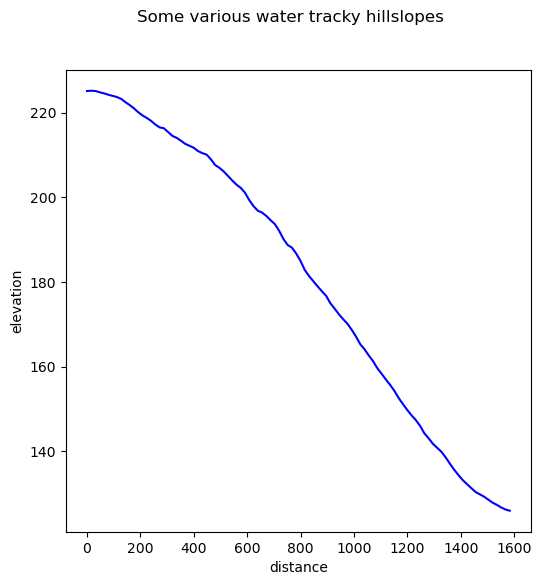

In [94]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6,6))

for line, group in transects.groupby(by='line_number'):

    group.plot(x='distance',y='mean', ax=ax,
                # legend=True, label="elevation",
               legend=False,
                  c='blue')

    # ax2 = ax.twinx()

    # group.plot.scatter(x='distance',y='gradient', ax=ax2, legend=True, label="gradient", c="orange")

    # ax2.legend(loc=3)

ax.set_xlabel('distance')
ax.set_ylabel('elevation')

plt.suptitle("Some various water tracky hillslopes")

In [95]:
geemap.ee_to_shp(ee.FeatureCollection(Map.draw_features), filename='new_line4.shp')

## Example plotting topographic data

In [20]:
# gdf = gpd.read_file('arctic_transects.shp')
# gdf.explore()

In [25]:
transects

,line_number,mean,distance
0,0,118.926292,0.000000
1,0,118.889143,23.440980
2,0,118.608573,46.881960
3,0,118.380632,70.322940
4,0,118.140596,93.763920
...,...,...,...
95,0,83.719727,2226.893102
96,0,83.040028,2250.334082
97,0,82.484478,2273.775062
98,0,82.452522,2297.216042


In [26]:
transects['gradient'] = (transects['mean'].diff()) / (transects['distance'].diff())

Text(0.5, 0.98, 'Some various water tracky hillslopes')

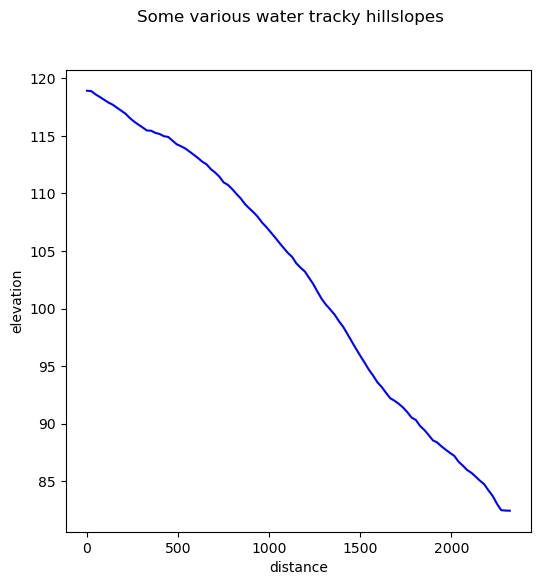

In [27]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6,6))

for line, group in transects.groupby(by='line_number'):

    group.plot(x='distance',y='mean', ax=ax,
                # legend=True, label="elevation",
               legend=False,
                  c='blue')

    # ax2 = ax.twinx()

    # group.plot.scatter(x='distance',y='gradient', ax=ax2, legend=True, label="gradient", c="orange")

    # ax2.legend(loc=3)

ax.set_xlabel('distance')
ax.set_ylabel('elevation')

plt.suptitle("Some various water tracky hillslopes")

In [96]:
# transects.to_csv(f"{HYBAS_ID}.csv")
transects.to_csv("new_line4.csv")

# Start here with all the data already

In [105]:
transects.loc[transects['line_number']!=4, :]

,distance,mean,line_number,Unnamed: 0,gradient
0,0.000000,225.094119,0,NaN,NaN
1,15.991549,225.163924,0,NaN,NaN
2,31.983098,225.088622,0,NaN,NaN
3,47.974647,224.778559,0,NaN,NaN
4,63.966196,224.529007,0,NaN,NaN
...,...,...,...,...,...
95,2226.893102,83.719727,6,95.0,-0.020958
96,2250.334082,83.040028,6,96.0,-0.028996
97,2273.775062,82.484478,6,97.0,-0.023700
98,2297.216042,82.452522,6,98.0,-0.001363


In [106]:
transects = pd.read_csv('all_profiles.csv')
transects = transects.loc[transects['line_number']!=4, :]

nun = pd.read_csv('nunavut_profiles.csv')
nun['line_number']=6

line4 = pd.read_csv('new_line4.csv')
line4['line_number']=4

transects = pd.concat([transects, nun, line4])

In [128]:
# for i, line in enumerate(transects.grouby('line_number')):
#     line['elev_normalized'] = line['mean'] - line['mean'].min()

transects['normalized'] = transects.groupby('line_number')['mean'].transform(lambda x: x - x.min())
transects

,Unnamed: 0,line_number,mean,distance,gradient,normalized
0,0,0,292.211799,0.000000,NaN,123.691559
1,1,0,291.520787,17.028059,-0.040581,123.000548
2,2,0,290.779190,34.056119,-0.043551,122.258950
3,3,0,290.101387,51.084178,-0.039805,121.581148
4,4,0,289.326564,68.112238,-0.045503,120.806324
...,...,...,...,...,...,...
95,95,4,127.852304,1519.197165,NaN,1.892947
96,96,4,127.334403,1535.188714,NaN,1.375045
97,97,4,126.718580,1551.180263,NaN,0.759223
98,98,4,126.253757,1567.171812,NaN,0.294400


In [129]:
def fit_quadratic(profile):
    x = profile['distance']
    y = profile['normalized']
    coeffs = np.polyfit(x, y, 2)
    return coeffs

In [130]:
# Group by line_number and apply the fitting function
grouped = transects.groupby('line_number').apply(fit_quadratic)

# Convert coefficients to DataFrame
coefficients_df = pd.DataFrame(grouped.tolist(), columns=['A', 'B', 'C'], index=grouped.index)

coefficients_df


,A,B,C
line_number,,,
0,-1.937933e-05,-0.046950,125.938098
1,-6.851500e-06,-0.041215,23.777408
2,9.942438e-07,-0.103248,220.319225
3,-9.145694e-06,-0.045869,117.894691
4,-1.786351e-05,-0.042271,103.490845
5,-1.826450e-05,-0.036859,128.661251
6,-2.254318e-06,-0.011889,37.682829


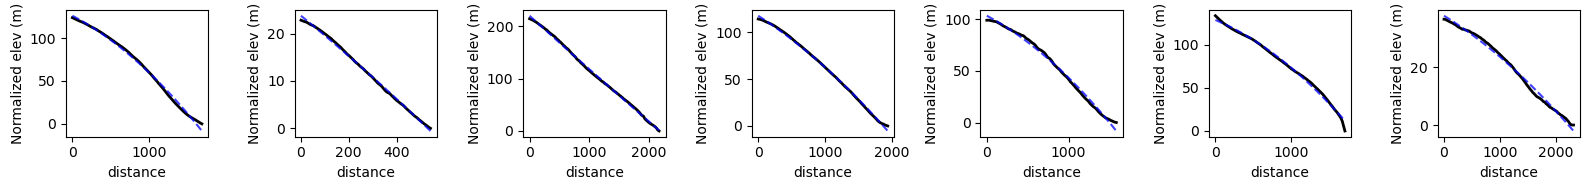

In [143]:
fig, ax = plt.subplots(1,7, figsize=(16,2))
for i, (line, data) in enumerate(transects.groupby('line_number')):
    quadfit = np.poly1d(coefficients_df.loc[i])
    data.plot(x='distance',y='normalized', ax=ax[i],
                # legend=True, label="elevation",
               legend=False,
                  c='k', linewidth=2)
    ax[i].plot(data['distance'].values, quadfit(data['distance'].values), '--b',alpha=0.75)
    ax[i].set_ylabel("Normalized elev (m)")
fig.tight_layout()